In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=str(0)

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from models import seq2point_gaussian

In [4]:
train ={ 
    1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    }
}
test = {
     2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
}
appliances = ["Dish Washer"]

In [5]:
datas = dataset_load(appliances, train, test, 99,split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test,y_test = datas[4],datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [6]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[:,0]
calibration_predictions_df['Ground Truth']=scaler_y.inverse_transform(y_cal)[:,0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test


## Seq2point

In [7]:
model = seq2point_gaussian.seq2point()


In [8]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

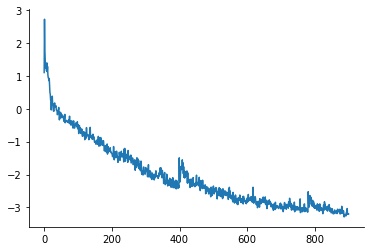

In [9]:
plt.plot(losses)
sns.despine()

In [10]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 13.5 s'

#### Training Results

In [11]:
y_hat = model.apply(params, x_train, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [12]:
train_mean = scaler_y.inverse_transform(y_hat[0])
train_sigma = scaler_y.scale_*y_hat[1]
y_true = scaler_y.inverse_transform(y_train)

In [13]:
print(f"RMSE : {errors.rmse(y_true, train_mean):.4f} MAE  : {errors.mae(y_true, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_true):.4f}")

RMSE : 85.6968 MAE  : 12.3584 NLL : 2.0193


In [14]:
training_predictions_df['mean']=train_mean
training_predictions_df['sigma']=train_sigma
training_predictions_df.head()

,Ground Truth,mean,sigma
0,1.000000e+00,1.528502,0.827875
1,1.000000e+00,2.039409,0.805458
2,1.000000e+00,1.956446,0.791052
3,8.209751e-08,1.112957,0.581232
4,6.875001e-01,1.420986,1.018961


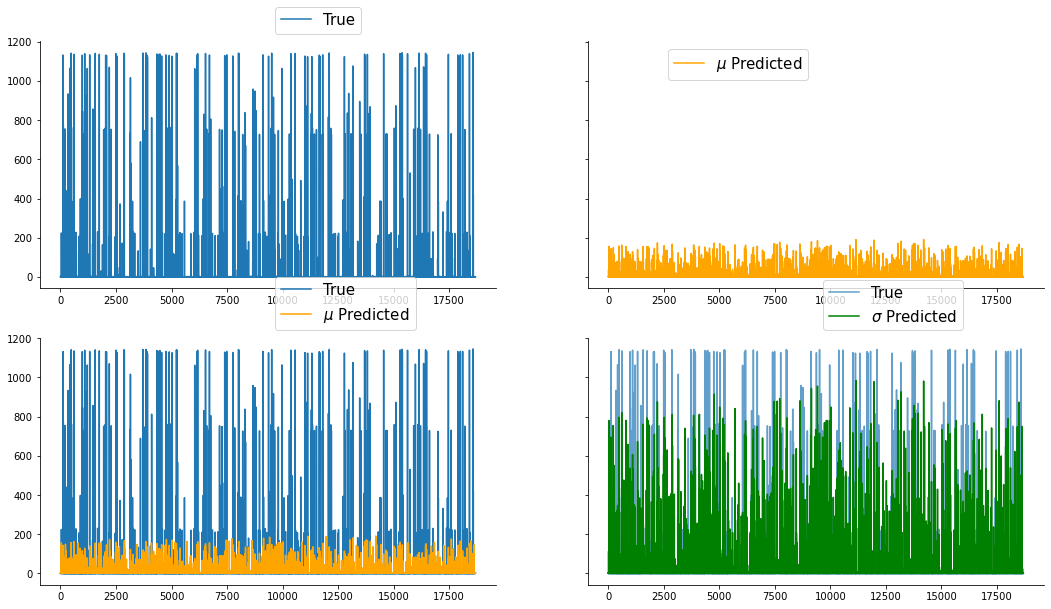

In [15]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10),sharey='row')
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Calibration Set Results

In [16]:
y_hat_cal = model.apply(params, x_cal, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [17]:
cal_mean = scaler_y.inverse_transform(y_hat_cal[0])
cal_sigma = scaler_y.scale_*y_hat_cal[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [18]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 78.0091 MAE  : 10.6508 NLL : 1.9928


In [19]:
calibration_predictions_df['mean']=cal_mean
calibration_predictions_df['sigma']=cal_sigma

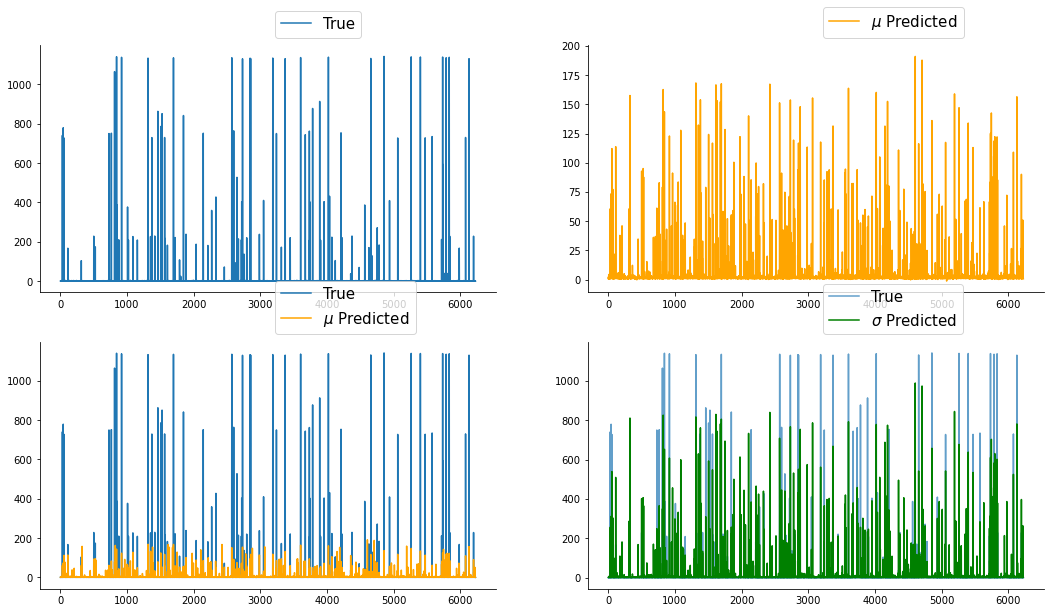

In [20]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Testing Results

In [21]:
%%capture cap
%%time
y_hat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})


In [22]:
test_mean = scaler_y.inverse_transform(y_hat[0])
test_sigma = scaler_y.scale_*y_hat[1]

In [23]:
mlp_testing_time = cap.stdout.split('\n')[1]

In [24]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test,test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 92.0509 MAE  : 9.6114 NLL : 1.6615


In [25]:
testing_predictions_df["mean"] = test_mean
testing_predictions_df["sigma"] = test_sigma

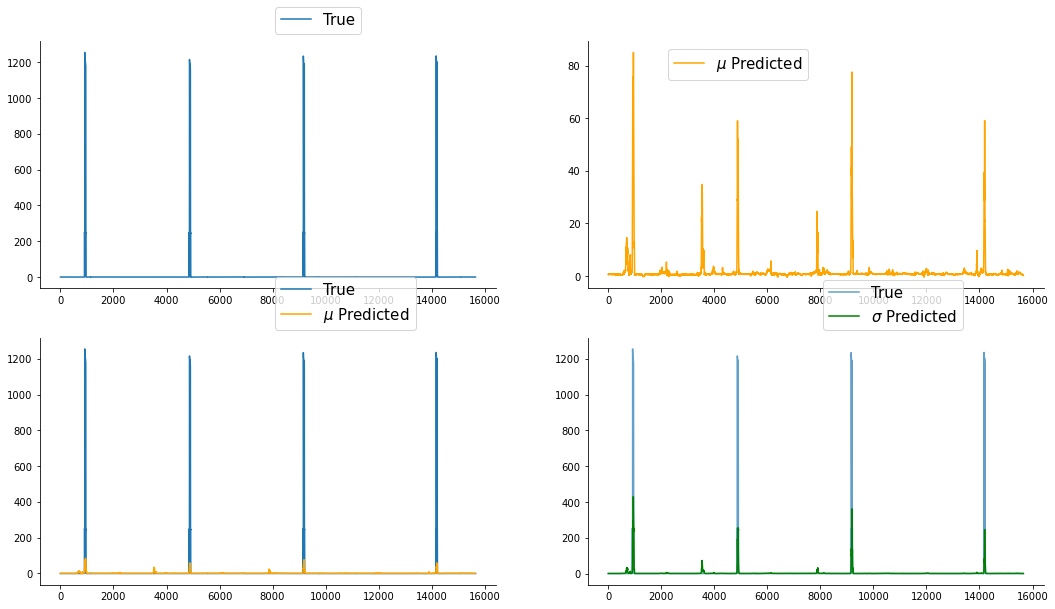

In [26]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Calibration

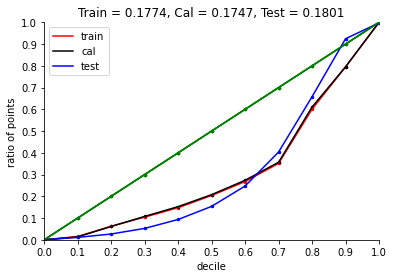

In [27]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(train_mean.squeeze(), train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(cal_mean.squeeze(), cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(test_mean.squeeze(), test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## MC Dropout

In [28]:
n_stacks = 10
fn = lambda x, i : model.apply(params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})

#### Training Results

In [29]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_train, jnp.arange(n_stacks))

2022-07-23 13:58:22.595214: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[186880,99,50]{1,2,0}, u8[0]{0}) custom-call(f32[186880,99,50]{1,2,0}, f32[5,50,50]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


In [30]:
mc_train_mean,mc_train_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [31]:
mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)

In [32]:
print(f"RMSE : {errors.rmse(y_true, mc_train_mean):.4f}", f"MAE  : {errors.mae(y_true, mc_train_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_train_mean, mc_train_sigma, y_true):.4f}")

RMSE : 86.7222 MAE  : 11.7272 NLL  : 1.3943


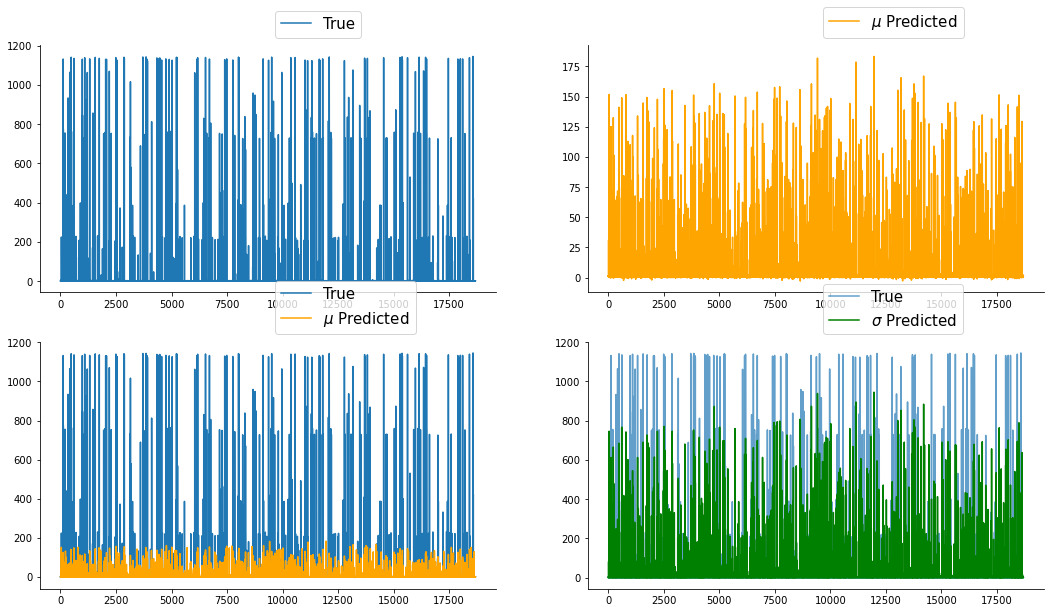

In [33]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [34]:
training_predictions_df['MC_mean']=mc_train_mean
training_predictions_df['MC_sigma']=mc_train_sigma

#### Calibration Set Results

In [35]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_cal, jnp.arange(n_stacks))

In [36]:
mc_cal_mean,mc_cal_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [37]:
mc_cal_mean = scaler_y.inverse_transform(mc_cal_mean)
mc_cal_sigma = (scaler_y.scale_*mc_cal_sigma)

In [38]:
print(f"RMSE : {errors.rmse(y_true_cal, mc_cal_mean):.4f}", f"MAE  : {errors.mae(y_true_cal, mc_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_cal_mean, mc_cal_sigma, y_true_cal):.4f}")

RMSE : 78.9770 MAE  : 10.0295 NLL  : 1.3676


In [39]:
calibration_predictions_df['MC_Mean'] =mc_cal_mean
calibration_predictions_df['MC_Sigma'] =mc_cal_sigma

#### Testing Results

In [40]:
%%capture cap
%%time
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_test, jnp.arange(n_stacks))

2022-07-23 13:58:27.637527: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[156560,99,50]{1,2,0}, u8[0]{0}) custom-call(f32[156560,99,50]{1,2,0}, f32[5,50,50]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


In [41]:
mc_testing_time = cap.stdout.split('\n')[1]
mc_testing_time

'Wall time: 2.25 s'

In [42]:
mc_test_mean,mc_test_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [43]:
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)

In [44]:
print(f"RMSE : {errors.rmse(y_test, mc_test_mean):.4f}", f"MAE  : {errors.mae(y_test, mc_test_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_test_mean, mc_test_sigma, y_test):.4f}")

RMSE : 92.7513 MAE  : 9.2633 NLL  : 1.4391


In [45]:
testing_predictions_df['MC_Mean'] =  mc_test_mean
testing_predictions_df['MC_Sigma'] = mc_test_sigma

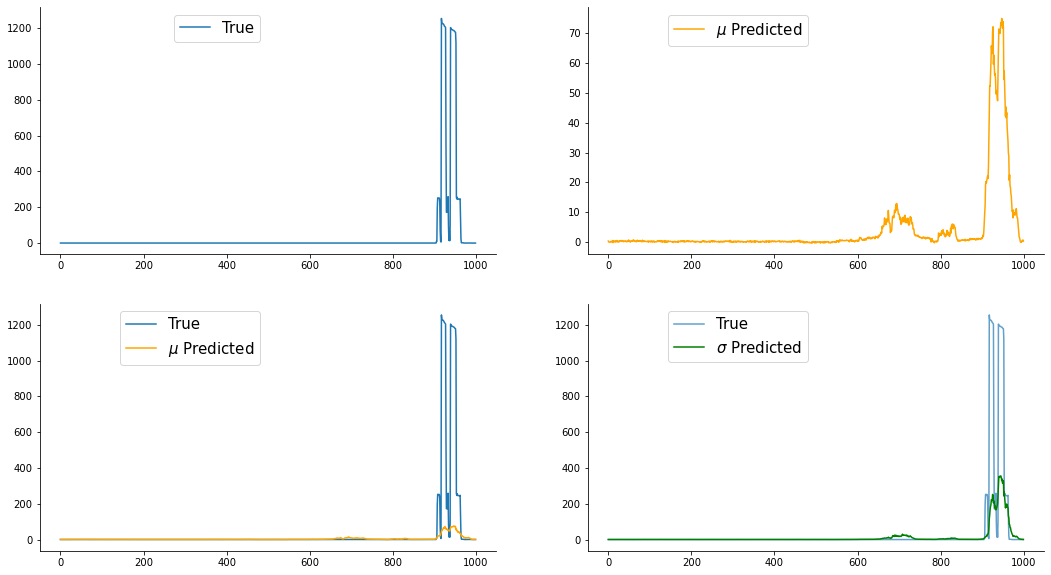

In [46]:
idx1 = 0
idx2 = 1000
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

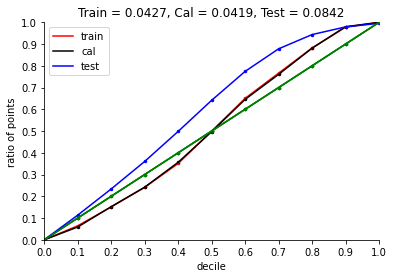

In [47]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(mc_train_mean.squeeze(), mc_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(mc_cal_mean.squeeze(), mc_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(mc_test_mean.squeeze(), mc_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Deep Ensemble

In [48]:
def de_train(x, y, i, model):
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=1024, 
                      learning_rate=0.0001, epochs=50)
    return param, losses
    
de_train = jax.tree_util.Partial(de_train, model=model)

def predict(x, param, model):
    yhat = model.apply(param,x,True)
    return yhat
test_ = jax.tree_util.Partial(predict, model=model)

In [49]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

2022-07-23 13:58:33.538221: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[8,30,300]{0,2,1}, u8[0]{0}) custom-call(f32[10240,106,30]{1,0,2}, f32[1024,99,300]{1,0,2}), window={size=99}, dim_labels=f0b_i0o->0bf, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


In [50]:
de_training_time = cap.stdout.split('\n')[1]
de_training_time

'Wall time: 1min 4s'

#### Training Results

In [51]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
de_train_mean,de_train_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

2022-07-23 13:59:37.126779: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[18688,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[18688,99,400]{1,2,0}, f32[5,40,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-23 13:59:38.626446: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[18688,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[18688,99,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\

In [52]:
de_train_mean = scaler_y.inverse_transform(de_train_mean)
de_train_sigma = (scaler_y.scale_*de_train_sigma)


In [53]:
print(f"RMSE : {errors.rmse(y_true, de_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, de_train_mean):.4f}", 
      f"NLL  : {errors.NLL(de_train_mean, de_train_sigma, y_true):.4f}")

RMSE : 86.8502 MAE  : 13.3271 NLL  : 2.0506


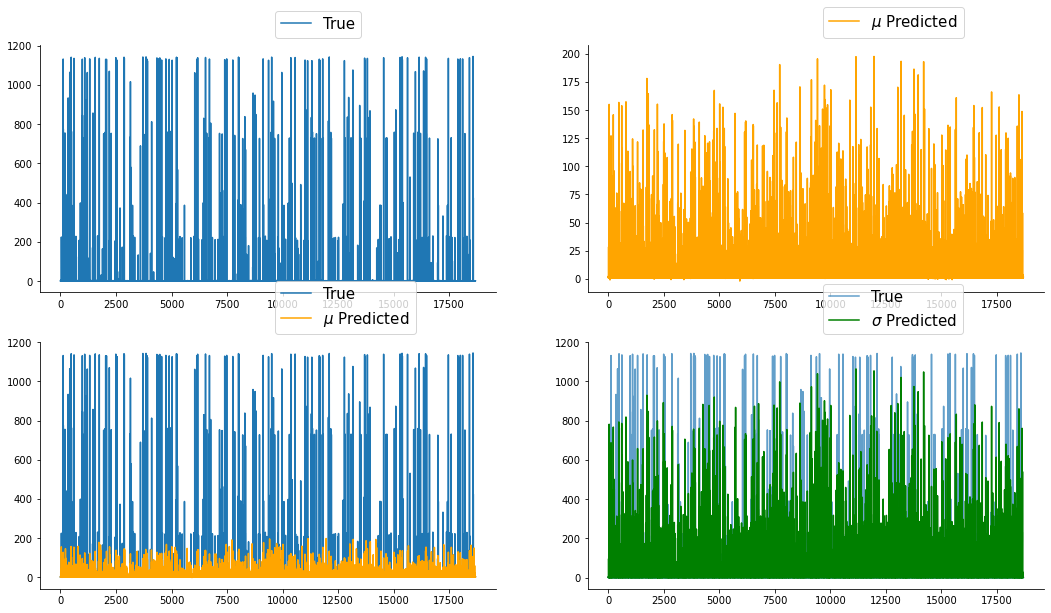

In [54]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [55]:
training_predictions_df['DE_mean']=de_train_mean
training_predictions_df['DE_sigma']=de_train_sigma

#### Calibration Set Results

In [56]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
de_cal_mean,de_cal_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [57]:
de_cal_mean = scaler_y.inverse_transform(de_cal_mean)
de_cal_sigma = (scaler_y.scale_*de_cal_sigma)



In [58]:
print(f"RMSE : {errors.rmse(y_true_cal, de_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, de_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(de_cal_mean, de_cal_sigma, y_true_cal):.4f}")

RMSE : 79.2335 MAE  : 11.7189 NLL  : 2.0428


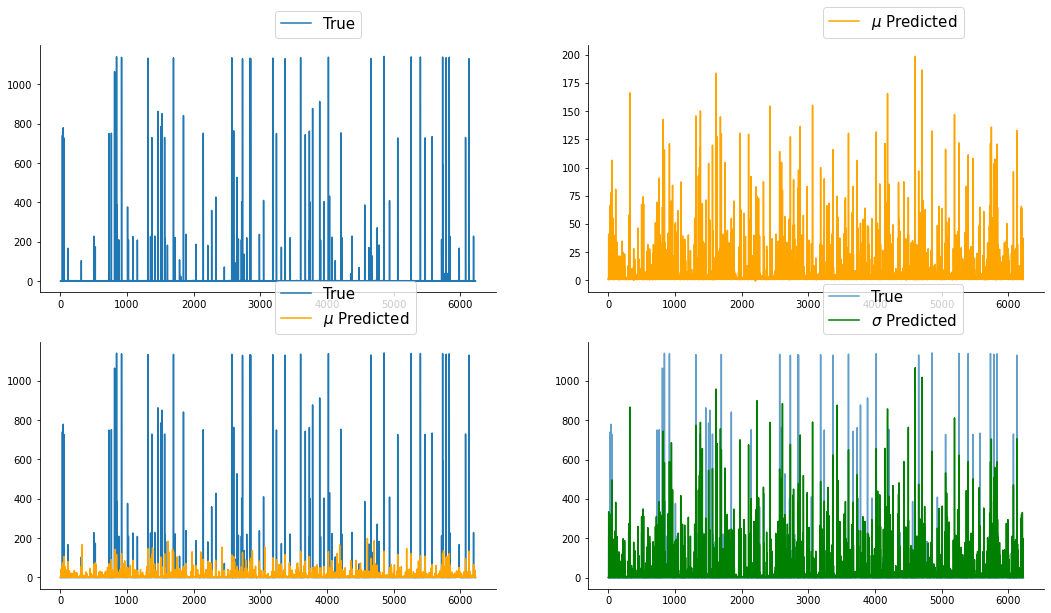

In [59]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [60]:
calibration_predictions_df['DE_mean']=de_cal_mean
calibration_predictions_df['DE_sigma']=de_cal_sigma

In [61]:
calibration_predictions_df.head()

,Ground Truth,mean,sigma,MC_Mean,MC_Sigma,DE_mean,DE_sigma
0,8.209751e-08,0.919895,0.588559,0.468963,0.491263,0.648710,0.517591
1,8.209751e-08,1.232033,0.839705,1.106982,1.029944,0.947357,0.641825
2,1.000000e+00,2.081193,0.831920,1.726783,0.784571,1.853796,0.703616
3,8.209751e-08,0.966266,0.657481,0.857852,0.669055,0.757705,0.567900
4,9.375001e-01,2.193991,1.386747,1.709453,1.133453,1.888756,1.234591


#### Testing Results

In [62]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_test, params_list)

2022-07-23 13:59:45.523991: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[15656,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[15656,99,400]{1,2,0}, f32[5,40,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-23 13:59:46.783473: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[15656,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[15656,99,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\

In [63]:
de_testing_time = cap.stdout.split('\n')[1]
de_testing_time

'Wall time: 4.11 s'

In [64]:
de_test_mean,de_test_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [65]:
de_test_mean = scaler_y.inverse_transform(de_test_mean)
de_test_sigma = (scaler_y.scale_*de_test_sigma)

In [66]:
testing_predictions_df['de_Mean'] =  de_test_mean
testing_predictions_df['de_Sigma'] = de_test_sigma

In [67]:
print(f"RMSE : {errors.rmse(y_test, de_test_mean):.4f}", f"MAE  : {errors.mae(y_test, de_test_mean):.4f}", 
      f"NLL  : {errors.NLL(de_test_mean, de_test_sigma, y_test):.4f}")

RMSE : 94.2261 MAE  : 9.8843 NLL  : 2.7753


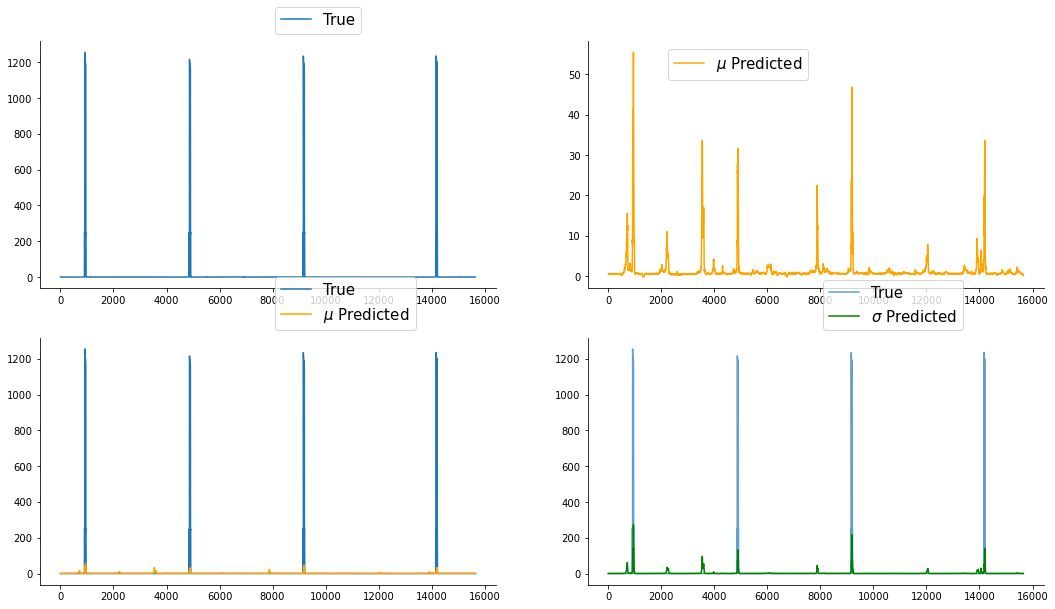

In [68]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

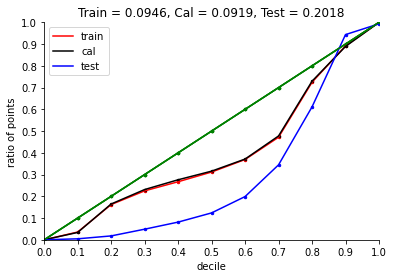

In [69]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(de_train_mean.squeeze(), de_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(de_cal_mean.squeeze(), de_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(de_test_mean.squeeze(), de_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Bootstrap

In [70]:
def bs_train(x, y, i, model):
    idx = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(len(x)), (len(x),))
    new_x, new_y = x[idx], y[idx]
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, new_x, new_y, True, batch_size=1024, 
                      learning_rate=0.0001, epochs= 50)
    return param, losses

bs_train = jax.tree_util.Partial(bs_train, model=model)

In [71]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(bs_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [72]:
bs_training_time = cap.stdout.split('\n')[1]
bs_training_time

'Wall time: 1min 5s'

#### Training Results

In [73]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
bs_train_mean,bs_train_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [74]:
bs_train_mean = scaler_y.inverse_transform(bs_train_mean)
bs_train_sigma = scaler_y.scale_*bs_train_sigma

In [75]:
print(f"RMSE : {errors.rmse(y_true, bs_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, bs_train_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_train_mean, bs_train_sigma, y_true):.4f}")

RMSE : 89.3217 MAE  : 14.0541 NLL  : 3.5805


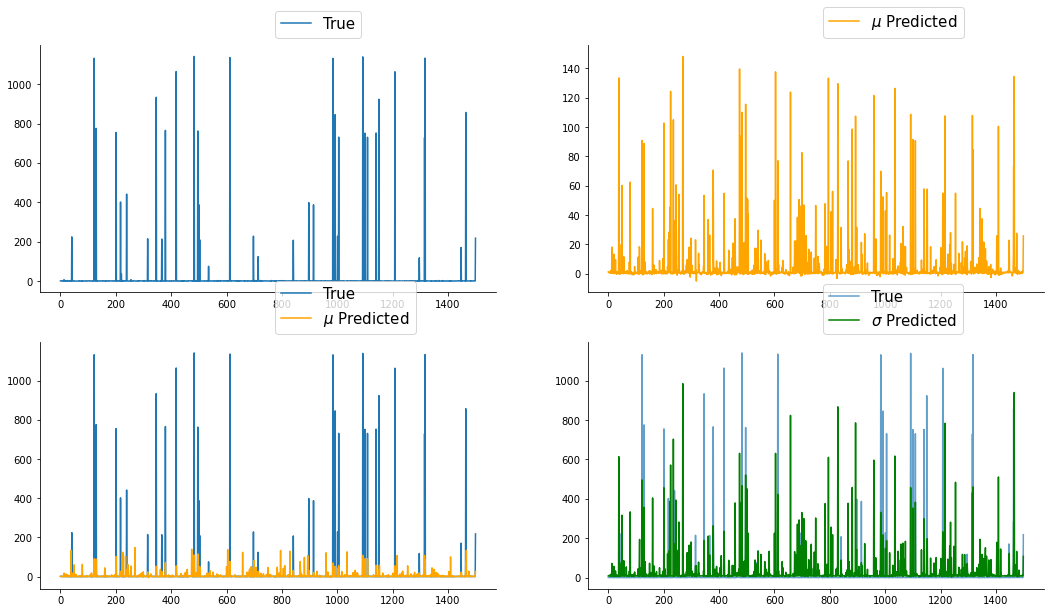

In [76]:
idx1 = 0
idx2 = 1500
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [77]:
training_predictions_df['BS_mean']=bs_train_mean
training_predictions_df['BS_sigma']=bs_train_sigma

#### Calibration Set Results

In [78]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
bs_cal_mean,bs_cal_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [79]:
bs_cal_mean = scaler_y.inverse_transform(bs_cal_mean)
bs_cal_sigma = scaler_y.scale_*bs_cal_sigma

In [80]:
print(f"RMSE : {errors.rmse(y_true_cal, bs_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, bs_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_cal_mean, bs_cal_sigma, y_true_cal):.4f}")

RMSE : 81.9116 MAE  : 12.5278 NLL  : 3.5711


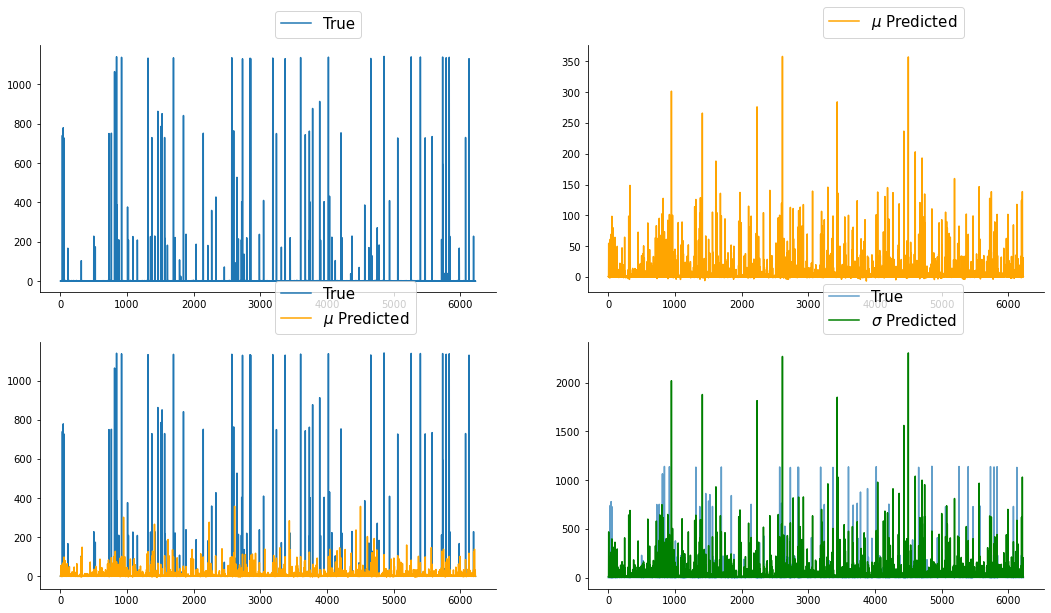

In [81]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [82]:
calibration_predictions_df['bs_Mean'] =  bs_cal_mean
calibration_predictions_df['bs_Sigma'] = bs_cal_sigma

#### Testing Results

In [83]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_test, params_list)

In [84]:
bs_testing_time = cap.stdout.split('\n')[1]
bs_testing_time

'Wall time: 268 ms'

In [85]:
bs_test_mean,bs_test_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [86]:
bs_test_mean = scaler_y.inverse_transform(bs_test_mean)
bs_test_sigma = scaler_y.scale_*bs_test_sigma

In [87]:
print(f"RMSE : {errors.rmse(y_test, bs_test_mean):.4f}", f"MAE  : {errors.mae(y_test, bs_test_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_test_mean, bs_test_sigma, y_test):.4f}")

RMSE : 93.8866 MAE  : 10.2189 NLL  : 3.5431


In [88]:
testing_predictions_df['bs_Mean'] =  bs_test_mean
testing_predictions_df['bs_Sigma'] = bs_test_sigma

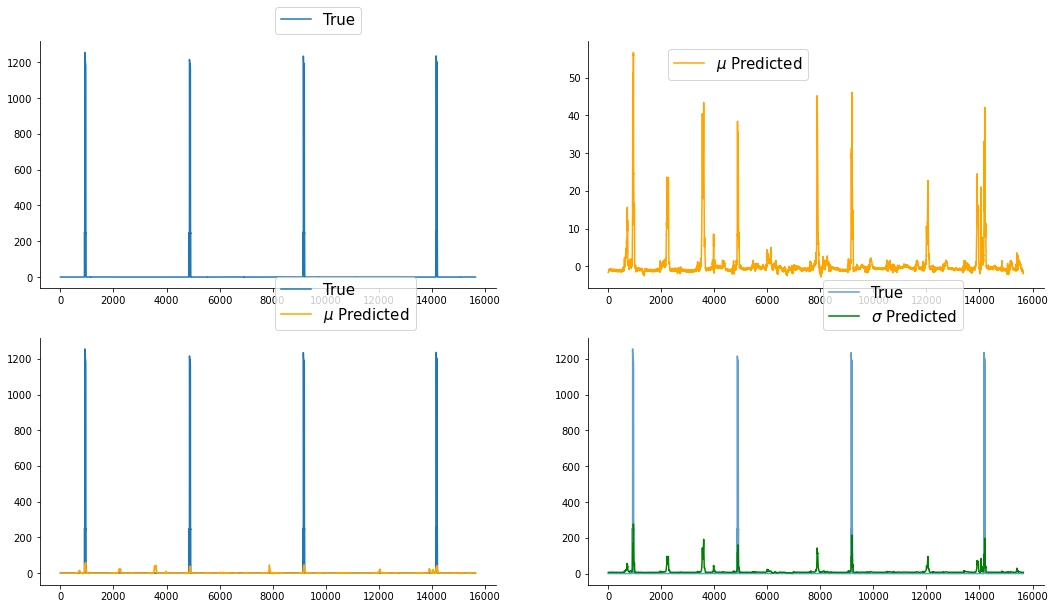

In [89]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

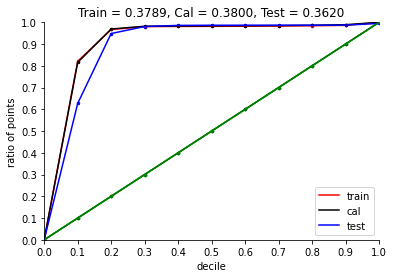

In [90]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(bs_train_mean.squeeze(), bs_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(bs_cal_mean.squeeze(), bs_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(bs_test_mean.squeeze(), bs_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Save Results

In [91]:
testing_predictions_df.head()

,Timestamp,Ground Truth,mean,sigma,MC_Mean,MC_Sigma,de_Mean,de_Sigma,bs_Mean,bs_Sigma
0,2011-04-21 00:00:00-04:00,0.1250,0.560691,0.455069,0.304496,0.463558,0.488107,0.389192,-1.572591,6.280275
1,2011-04-21 00:01:00-04:00,0.1250,0.540723,0.452637,0.041602,0.374473,0.481756,0.388740,-1.620432,6.272551
2,2011-04-21 00:02:00-04:00,0.1250,0.589463,0.453883,-0.036667,0.426977,0.485934,0.388017,-1.552208,6.268858
3,2011-04-21 00:03:00-04:00,0.0625,0.619394,0.454820,-0.058678,0.320103,0.476148,0.388557,-1.578233,6.271600
4,2011-04-21 00:04:00-04:00,0.1250,0.582698,0.451035,-0.028519,0.358891,0.473976,0.389868,-1.594788,6.275545


In [92]:
training_predictions_df.to_csv("notebooks/dishwasher/s2p/gmlp/training_predictions.csv",index=False)
calibration_predictions_df.to_csv("notebooks/dishwasher/s2p/gmlp/calibration_predictions.csv",index=False)
testing_predictions_df.to_csv("notebooks/dishwasher/s2p/gmlp/testing_predictions.csv",index=False)

In [93]:
with open('notebooks/dishwasher/s2p/gmlp/time.txt', 'w') as file:
    file.writelines([f"MLP training :{mlp_training_time} ",f" MLP Testing : {mlp_testing_time}\n"
               f"MC Testing : {mc_testing_time}\n", 
               f"DE Training Time : {de_training_time} ",f" DE Testing Time: {de_testing_time}\n", 
               f"BS Training Time : {bs_training_time} ",f" BS Testing Time: {bs_testing_time}"])